# Import libraries and set seeds

In [9]:
import pandas as pd
import numpy as np
import matplotlib; matplotlib.rc_file_defaults()
import matplotlib.pyplot as plt
import seaborn as sn

import os
import random
import itertools as it
from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import LeaveOneOut
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

from xgboost import XGBClassifier

In [10]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

SEED = 1
set_seeds(seed=SEED)

# Load data

In [11]:
df = pd.read_csv('heart.csv')
test = df.sample(frac=.1, random_state=SEED)
df.drop(test.index, axis=0,inplace=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       273 non-null    int64  
 1   sex       273 non-null    int64  
 2   cp        273 non-null    int64  
 3   trestbps  273 non-null    int64  
 4   chol      273 non-null    int64  
 5   fbs       273 non-null    int64  
 6   restecg   273 non-null    int64  
 7   thalach   273 non-null    int64  
 8   exang     273 non-null    int64  
 9   oldpeak   273 non-null    float64
 10  slope     273 non-null    int64  
 11  ca        273 non-null    int64  
 12  thal      273 non-null    int64  
 13  target    273 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.0 KB


## EDA

In [13]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.483516,0.684982,0.952381,131.545788,246.380952,0.150183,0.549451,149.670330,0.329670,1.012454,1.406593,0.688645,2.289377,0.553114
std,9.039166,0.465376,1.029672,17.816433,51.873587,0.357907,0.527140,23.443795,0.470957,1.102567,0.617955,0.978697,0.618761,0.498084
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,154.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.000000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,5.600000,2.000000,4.000000,3.000000,1.000000


In [14]:
numerical = [
    'age',
    'trestbps',
    'chol',
    'thalach',
    'oldpeak',
]

categorical = [
    'sex',
    'cp',
    'fbs',
    'restecg',
    'exang',
    'slope',
    'ca',
    'thal',
    'target'
]

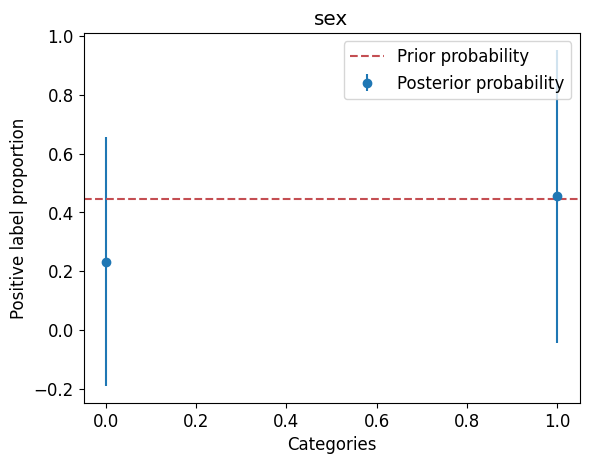

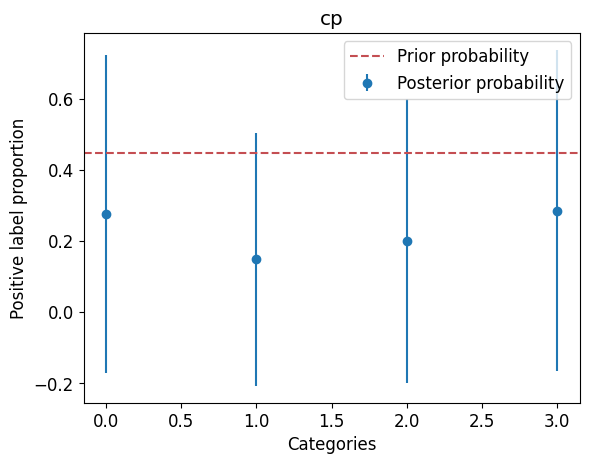

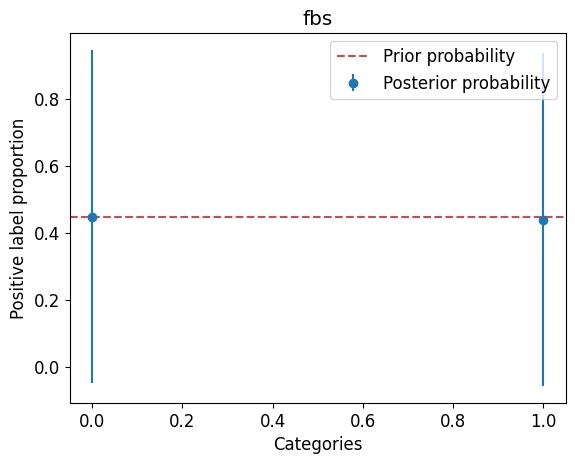

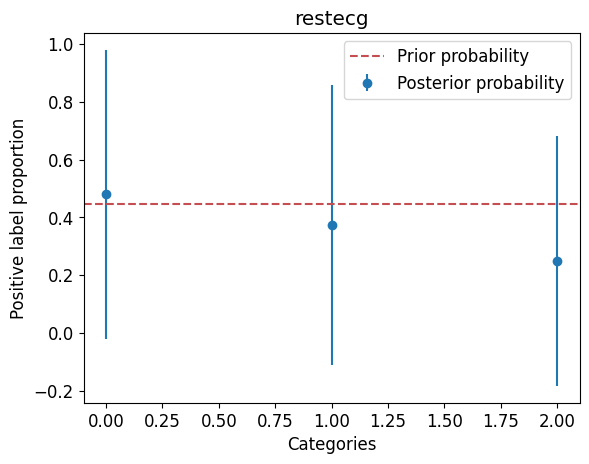

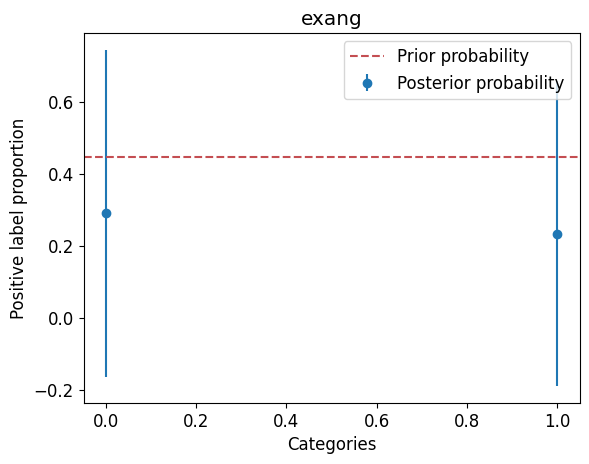

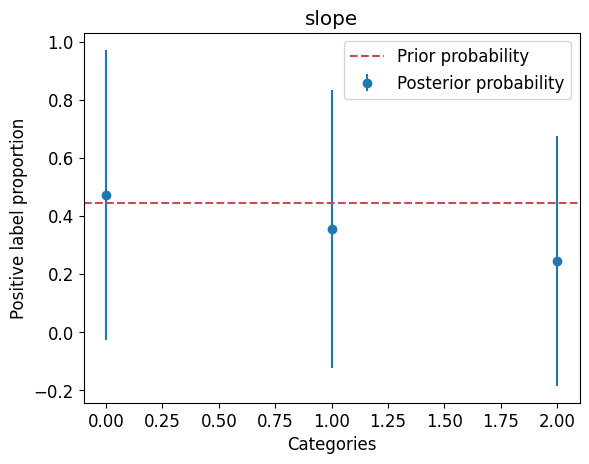

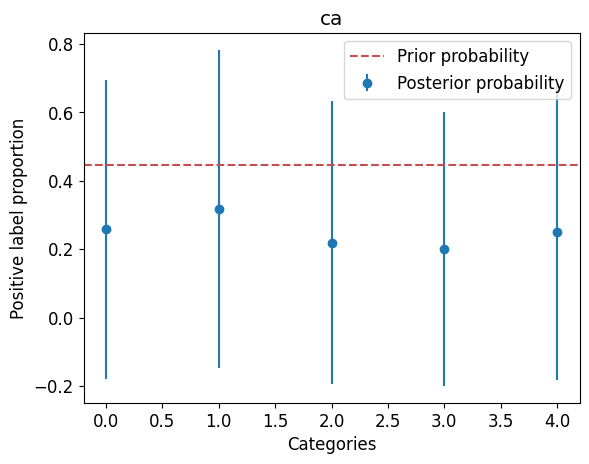

In [53]:
pos_proportion = df['target'].value_counts().values[1]/len(df)

for feature in categorical:
    categories = list()
    means = list()
    sds = list()
    try:
        for category in df[feature].unique():
                temp = df.loc[df[feature]==category, 'target']
                categories.append(category)
                means.append(temp.value_counts().values[1]/len(temp))
                sds.append(np.std(temp))

        plt.errorbar(x=categories, y=means, yerr=sds, fmt="o", label='Posterior probability')
        plt.axhline(y=pos_proportion, color='r', linestyle='--', label='Prior probability')
        plt.title(feature)
        plt.ylabel('Positive label proportion')
        plt.xlabel('Categories')
        plt.legend()
        plt.show()
    except:
        pass

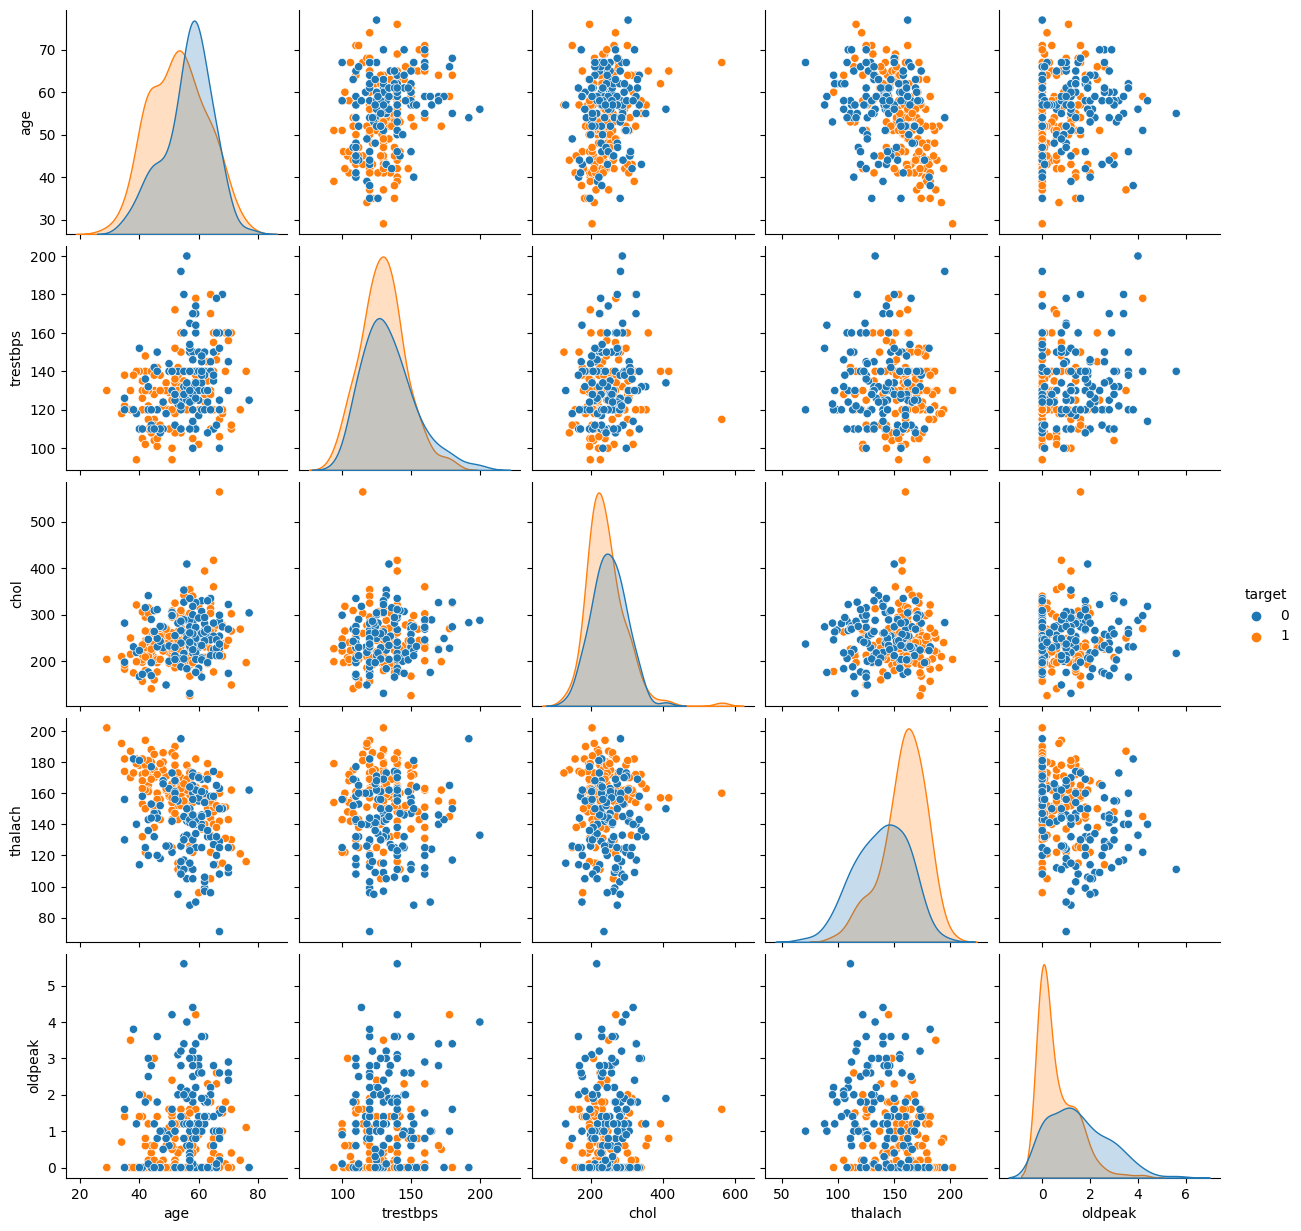

In [16]:
sn.pairplot(data=df[numerical + ['target']], hue='target')
plt.show()

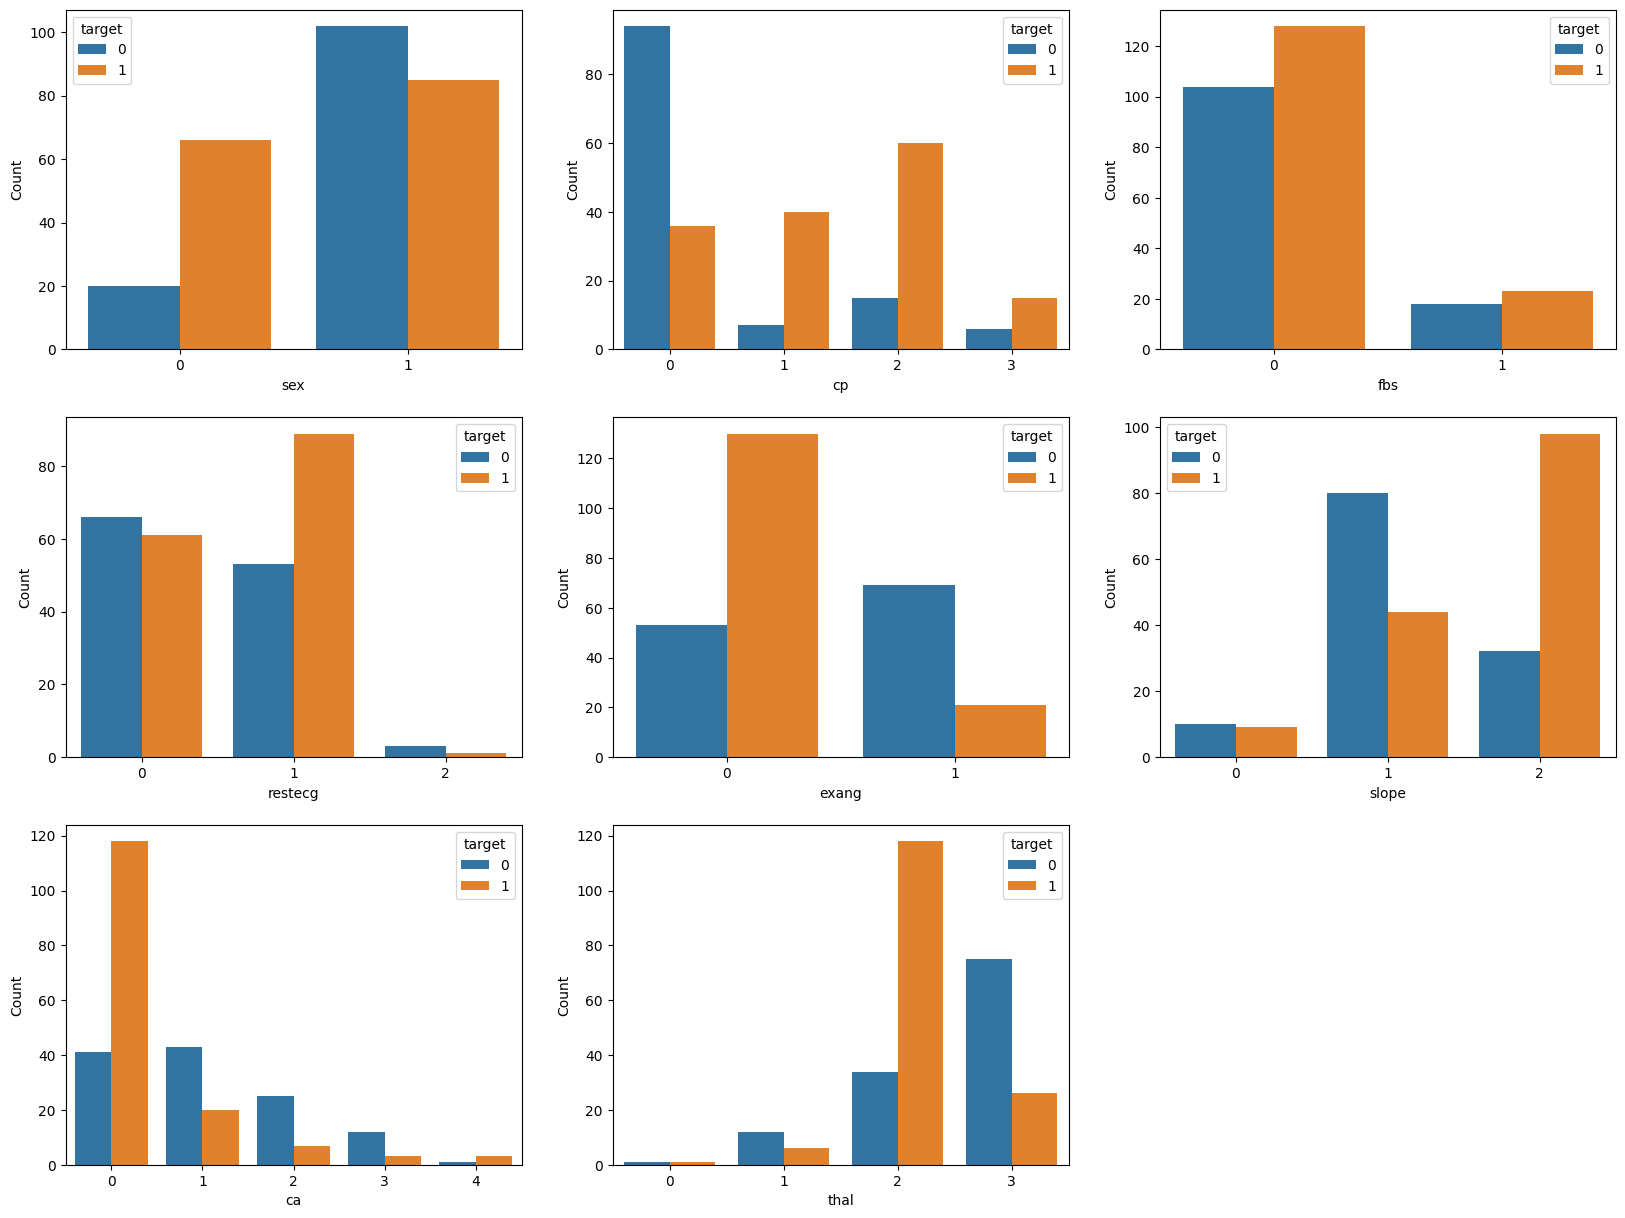

In [17]:
fig = plt.figure(figsize=(20,15))
x=1
for feature in categorical[:-1]:
    ax = fig.add_subplot(3,3,x)
    sn.countplot(x=feature,
                 hue='target',
                 data=df)
    plt.xlabel(feature)
    plt.ylabel('Count')
    x+=1
plt.show()

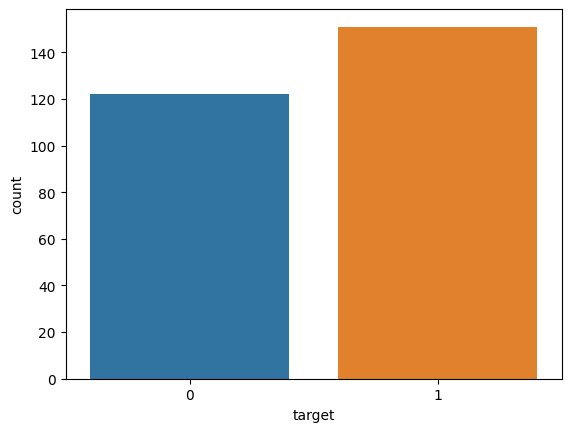

In [18]:
sn.countplot(x='target', data=df)
plt.show()

In [19]:
df['target'].value_counts()/len(df)

1    0.553114
0    0.446886
Name: target, dtype: float64

In [20]:
df['thal'].value_counts()/len(df)

2    0.556777
3    0.369963
1    0.065934
0    0.007326
Name: thal, dtype: float64

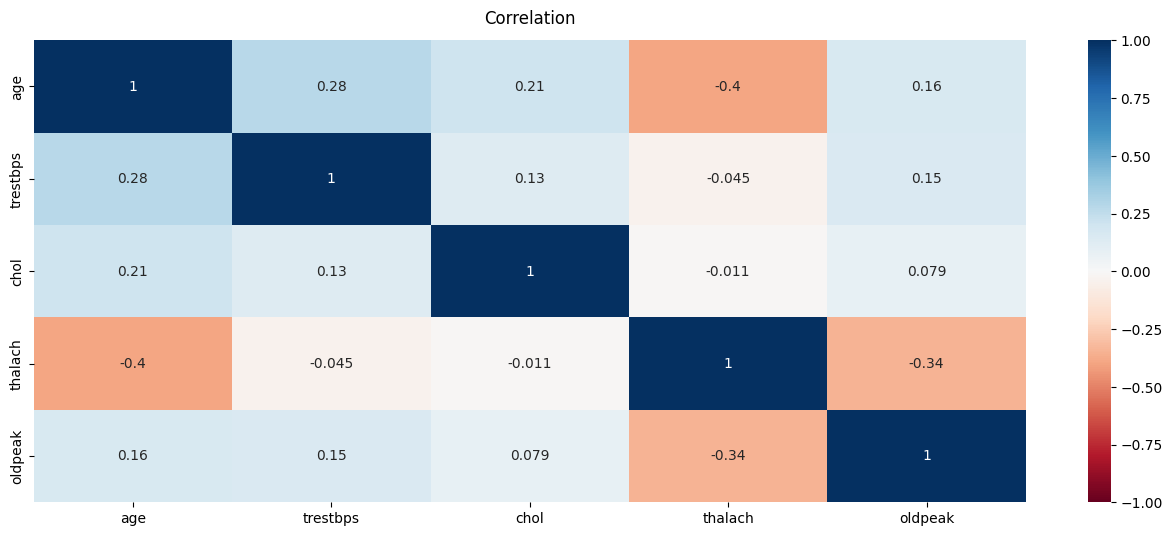

In [21]:
plt.figure(figsize=(16, 6))
sn.heatmap(df[numerical].corr(method='pearson'), annot=True, vmin=-1, vmax=1,cmap ="RdBu")
plt.title(
    'Correlation',
    fontdict={'fontsize':12}, pad=12)
plt.show()

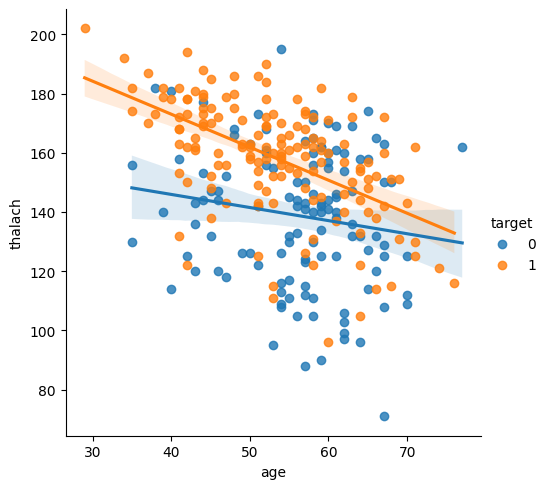

In [22]:
sn.lmplot(x='age', y='thalach', hue='target', data=df)
plt.show()

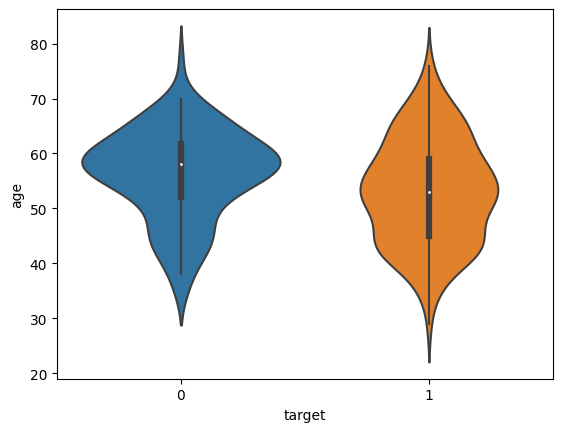

In [23]:
sn.violinplot(x='target', y='age', data=df)
plt.show()

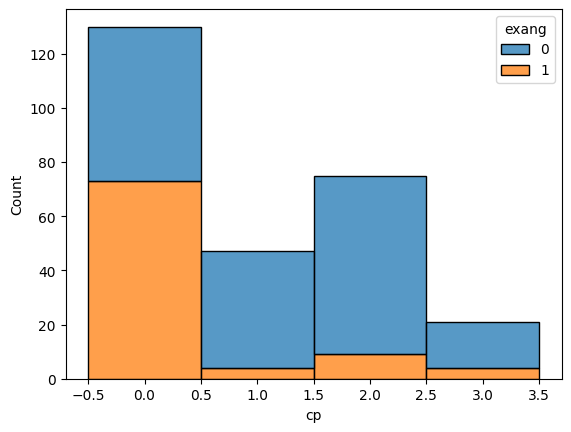

In [24]:
sn.histplot(discrete=True,x="cp", hue="exang", data=df,
             stat="count", multiple="stack")
plt.ylabel('Count')
plt.show()

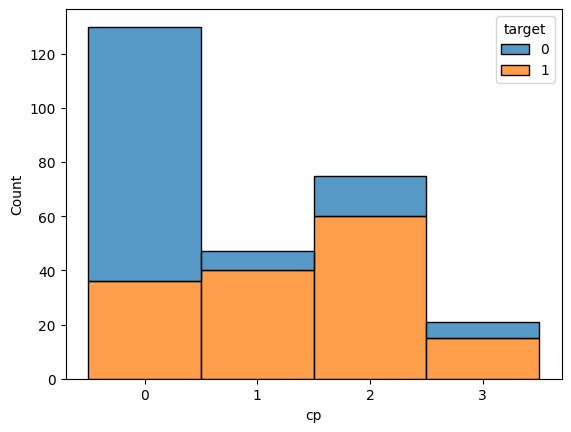

In [25]:
sn.histplot(discrete=True, x="cp", hue="target", data=df,
             stat="count", multiple="stack")
plt.ylabel('Count')
plt.xticks(ticks=[0,1,2,3])
plt.show()

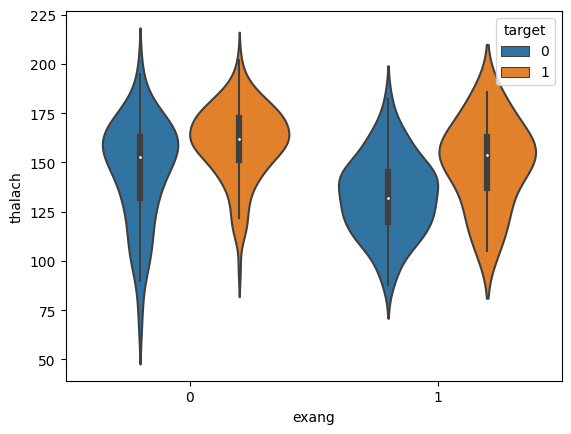

In [26]:
sn.violinplot(x='exang', y='thalach', data=df, hue='target')
plt.show()

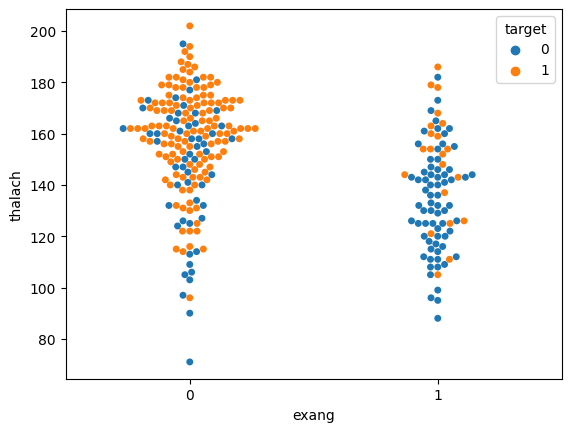

In [27]:
sn.swarmplot(data=df, y='thalach', x='exang',
              hue='target')
plt.show()

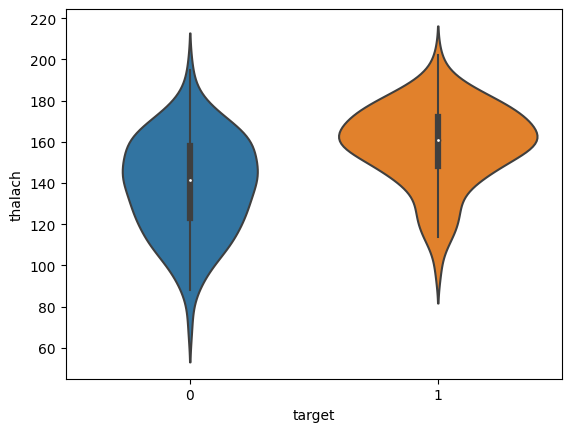

In [28]:
sn.violinplot(x='target', y='thalach', data=df)
plt.show()

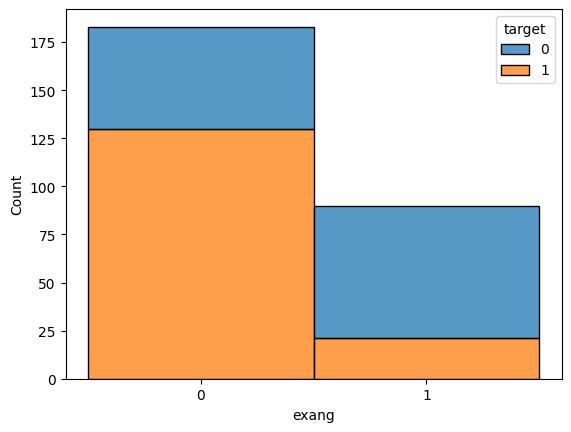

In [29]:
sn.histplot(discrete=True, x="exang", hue="target", data=df,
             stat="count", multiple="stack")
plt.ylabel('Count')
plt.xticks(ticks=[0,1])
plt.show()

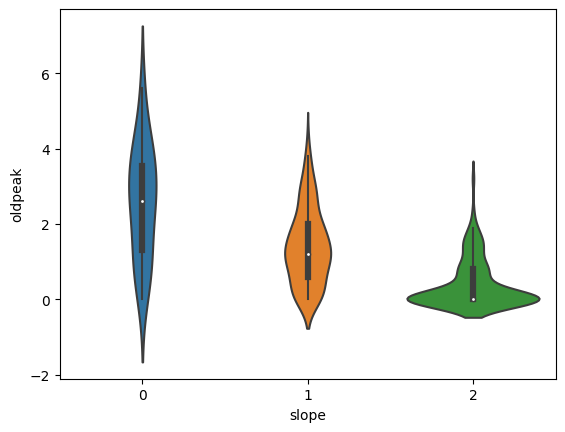

In [30]:
sn.violinplot(x='slope', y='oldpeak', data=df)
plt.show()

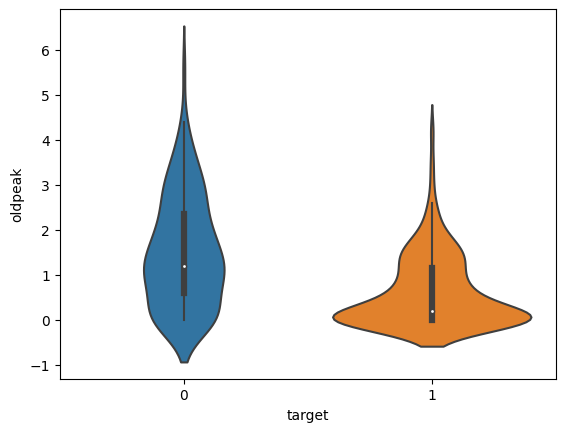

In [31]:
sn.violinplot(x='target', y='oldpeak', data=df)
plt.show()

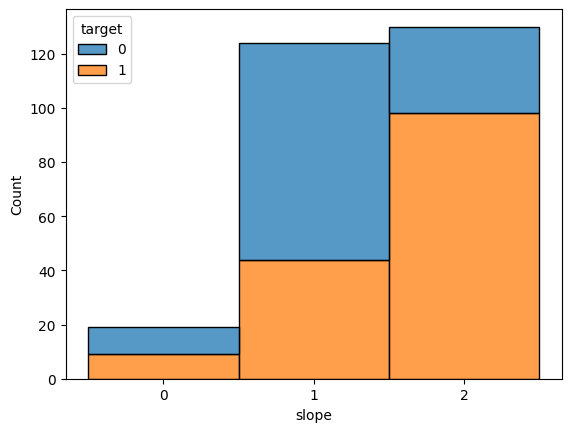

In [32]:
sn.histplot(discrete=True, x="slope", hue="target", data=df,
             stat="count", multiple="stack")
plt.ylabel('Count')
plt.xticks(ticks=[0,1,2])
plt.show()

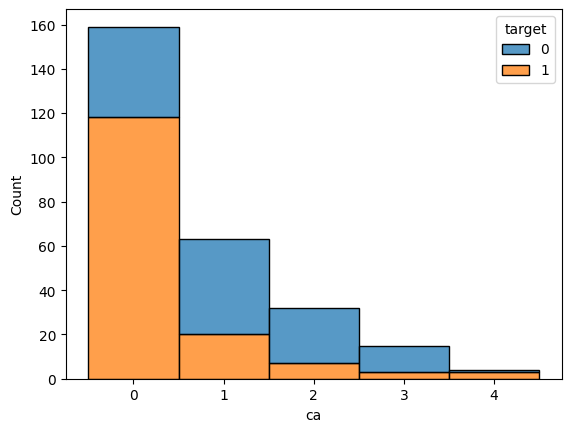

In [33]:
sn.histplot(discrete=True, x="ca", hue="target", data=df,
             stat="count", multiple="stack")
plt.ylabel('Count')
plt.xticks(ticks=[0,1,2,3,4])
plt.show()

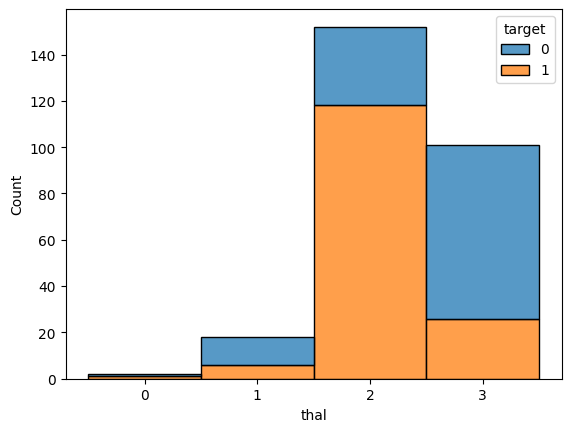

In [34]:
sn.histplot(discrete=True, x="thal", hue="target", data=df,
             stat="count", multiple="stack")
plt.ylabel('Count')
plt.xticks(ticks=[0,1,2,3])
plt.show()

# Cleaning and pre-processing

In [35]:
df.loc[df['thal'] == 0,'thal'] = np.nan
test.loc[test['thal'] == 0, 'thal'] = np.nan

train = df.copy()
target = train.pop('target')
categorical.remove('target')
all_features = train.columns

y_test = test.pop('target')

In [36]:
def impute(train_set, valid_set, get_pickles):
    '''Imputes training and validation/test sets with SimpleImputer.'''
    
    imputer = SimpleImputer(strategy='most_frequent')
    
    train_set = imputer.fit_transform(train_set)
    train_set = pd.DataFrame(train_set, columns=all_features)
    
    valid_set = imputer.transform(valid_set)
    valid_set = pd.DataFrame(valid_set, columns=all_features)
    
    if get_pickles:
        outfile = open('deployment/app/static/simple_imputer.pkl', 'wb')
        pickle.dump(imputer,outfile)
        outfile.close()
    else:
        pass
    
    return train_set, valid_set

In [37]:
def encode(train_set, valid_set, get_pickles):
    '''Encodes categorical variables in training and validation/test sets with OneHotEncoder.
    Returns encoded training and validation/test sets.
    '''
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    train_enc = pd.DataFrame(encoder.fit_transform(train_set[categorical]))
    train_enc.columns = encoder.get_feature_names(categorical)
    train_set = pd.concat([train_set[numerical], train_enc], axis=1)
    
    valid_enc = pd.DataFrame(encoder.transform(valid_set[categorical]))
    valid_enc.columns = encoder.get_feature_names(categorical)
    valid_set = pd.concat([valid_set[numerical], valid_enc], axis=1)
    
    if get_pickles:
        outfile = open('deployment/app/static/one_hot_encoder.pkl', 'wb')
        pickle.dump(encoder,outfile)
        outfile.close()
    else:
        pass
    
    return train_set, valid_set

In [38]:
def scale(train_set, valid_set, get_pickles):
    '''Scales numerical variables in training and validation/test sets with StandardScaler.
    Returns scaled training and validation/test sets.
    '''
    
    scaler = StandardScaler()

    train_set[numerical] = scaler.fit_transform(train_set[numerical])
    valid_set[numerical] = scaler.transform(valid_set[numerical])
    
    if get_pickles:
        outfile = open('deployment/app/static/standard_scaler.pkl', 'wb')
        pickle.dump(scaler,outfile)
        outfile.close()
    else:
        pass
    
    return train_set, valid_set

In [39]:
def preprocess(train_set, valid_set, inference=False, get_pickles=False):
    '''Combines impute, encode, and scale functions for use in cross-validation.
    Returns preprocessed training and validation/test sets.
    '''
    
    if inference:
        train_set, valid_set = impute(train_set, valid_set, get_pickles=get_pickles)        
        train_set, valid_set = encode(train_set, valid_set, get_pickles=get_pickles)
        return train_set.columns
    
    else:
        train_set, valid_set = impute(train_set, valid_set, get_pickles=get_pickles)        
        train_set, valid_set = encode(train_set, valid_set, get_pickles=get_pickles)
        train_set, valid_set = scale(train_set, valid_set, get_pickles=get_pickles)
        return train_set, valid_set

# Model selection

In [40]:
gnb = GaussianNB()
lr = LogisticRegression(max_iter=2000)
dt = DecisionTreeClassifier(random_state=SEED)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=SEED)
svc = SVC(probability=True)
xgb = XGBClassifier(eval_metric='error', random_state=SEED)

classifier_instances = [gnb, lr, dt, knn, rf, svc, xgb]
classifier_names = ["Gaussian Naive Bayes",
                    "Logistic Regression",
                    "Decision Tree",
                    "K-Nearest Neighbors",
                    "Random Forest",
                    "Support Vector Classifier",
                    "XGBoost"]

for idx, clf in enumerate(classifier_instances):
    
    model_name = classifier_names[idx]
    print(model_name)
    accuracies = list()
    recalls = list()
    loo = LeaveOneOut()
    for train_index, valid_index in loo.split(train):

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        if model_name == "XGBoost":
            pass
        else:
            X_train, X_valid = preprocess(X_train, X_valid)

        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_valid)

        accuracies.append(accuracy_score(y_valid, y_pred))
        recalls.append(recall_score(y_valid, y_pred))
        
    print("Accuracy:", np.round(np.mean(accuracies),4), "+/-", np.round(np.std(accuracies),4))
    print("Recall:", np.round(np.mean(recalls),4), "+/-", np.round(np.std(recalls),4), "\n")
    

Gaussian Naive Bayes
Accuracy: 0.8352 +/- 0.371
Recall: 0.4762 +/- 0.4994 

Logistic Regression
Accuracy: 0.8462 +/- 0.3608
Recall: 0.4872 +/- 0.4998 

Decision Tree
Accuracy: 0.7473 +/- 0.4346
Recall: 0.4322 +/- 0.4954 

K-Nearest Neighbors
Accuracy: 0.8278 +/- 0.3775
Recall: 0.4762 +/- 0.4994 

Random Forest
Accuracy: 0.8315 +/- 0.3743
Recall: 0.4725 +/- 0.4992 

Support Vector Classifier
Accuracy: 0.8425 +/- 0.3643
Recall: 0.4799 +/- 0.4996 

XGBoost
Accuracy: 0.7839 +/- 0.4116
Recall: 0.4579 +/- 0.4982 



# Model Tuning

In [41]:
def clf_performance(best_parameters, mean_acc, std_acc, mean_recall, std_recall, model_name):
    '''Prints results from gridsearch cross-validation.'''
    print(model_name)
    print('Best Accuracy: {} +/- {}'.format(str(np.round(mean_acc,4)),str(np.round(std_acc,4))))
    print('Corresponding Recall: {} +/- {}'.format(str(np.round(mean_recall,4)), str(np.round(std_recall,4))))
    print('Best Parameters: ' + str(best_parameters))

def grid_search_loocv(clf, clf_name, X, y, param_grid):
    '''Determines best parameters from parameter grid based on accuracy metric.
    Returns best parameters from grid search.
    '''
    
    parameters = list(param_grid.keys())
    combinations = list(it.product(*(param_grid[Name] for Name in param_grid)))
    
    parameter_combinations = []
    for idx, val in enumerate(combinations):
        parameter_set = dict(zip(parameters,val))
        parameter_combinations.append(parameter_set)
    
    best_params = 0
    best_mean_acc = 0
    best_std_acc = 0
    best_mean_recall = 0
    best_std_recall = 0
    for params in tqdm(parameter_combinations):
    
        acc = list()
        recall = list()
        loo = LeaveOneOut()
        for train_index, valid_index in loo.split(train):

            X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
            y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
            
            X_train, X_valid = preprocess(X_train, X_valid)

            clf.set_params(**params)
            y_pred = clf.fit(X_train, y_train).predict(X_valid)

            acc.append(accuracy_score(y_valid, y_pred))
            recall.append(recall_score(y_valid, y_pred))
            
        mean_acc = np.mean(acc)
        std_acc = np.std(acc)
        
        mean_recall = np.mean(recall)
        std_recall = np.std(recall)
        
        if mean_acc > best_mean_acc:
            best_params = params
            best_mean_acc = mean_acc
            best_std_acc = std_acc
            best_mean_recall = mean_recall
            best_std_recall = std_recall
            
    clf_performance(best_params, best_mean_acc, best_std_acc, best_mean_recall, best_std_recall, clf_name)
            
    return best_params

In [42]:
lr = LogisticRegression(solver='saga', max_iter=15000)
param_grid = {
                'penalty': ['l1', 'l2'],
                'C' : np.linspace(0.001, 0.1, 10)
             }
best_parameters = grid_search_loocv(lr, "Logistic Regression", train, target, param_grid)

100%|███████████████████████████████████████████| 20/20 [01:39<00:00,  4.98s/it]

Logistic Regression
Best Accuracy: 0.8425 +/- 0.3643
Corresponding Recall: 0.4872 +/- 0.4998
Best Parameters: {'penalty': 'l2', 'C': 0.067}


# Test set predictions and model evaluation

In [43]:
def final_predictions(train, test, y_test, best_parameters):
    '''Fits model with best parameters on all training data and computes class and probability predictions.
    Prints test set accuracy and recall, and returns class and probability predictions.
    '''
    
    X_train, X_test = preprocess(train, test, get_pickles=True)
    
    lr = LogisticRegression(solver='saga', max_iter=15000)
    lr.set_params(**best_parameters)
    y_pred = lr.fit(X_train, target).predict(X_test)
    y_pred_proba = lr.fit(X_train, target).predict_proba(X_test)
    
    print("Final model evaluated on test set")
    print("Accuracy:", np.round(accuracy_score(y_test, y_pred),4))
    print("Recall:", np.round(recall_score(y_test, y_pred),4))
    print("ROC AUC:", np.round(roc_auc_score(y_test, y_pred_proba[:,1]), 4))
    
    outfile = open('deployment/app/static/logistic_regression.pkl', 'wb')
    pickle.dump(lr,outfile)
    outfile.close()
    
    return y_pred, y_pred_proba

In [44]:
y_pred, y_pred_proba = final_predictions(train, test, y_test, best_parameters)

Final model evaluated on test set
Accuracy: 0.9
Recall: 1.0
ROC AUC: 0.9464


In [45]:
print("Test set class ratios")
ratios = np.round(y_test.value_counts()/len(y_test),4)
print(f"{ratios.index[0]}: {ratios.values[0]}")
print(f"{ratios.index[1]}: {ratios.values[1]}")

Test set class ratios
0: 0.5333
1: 0.4667


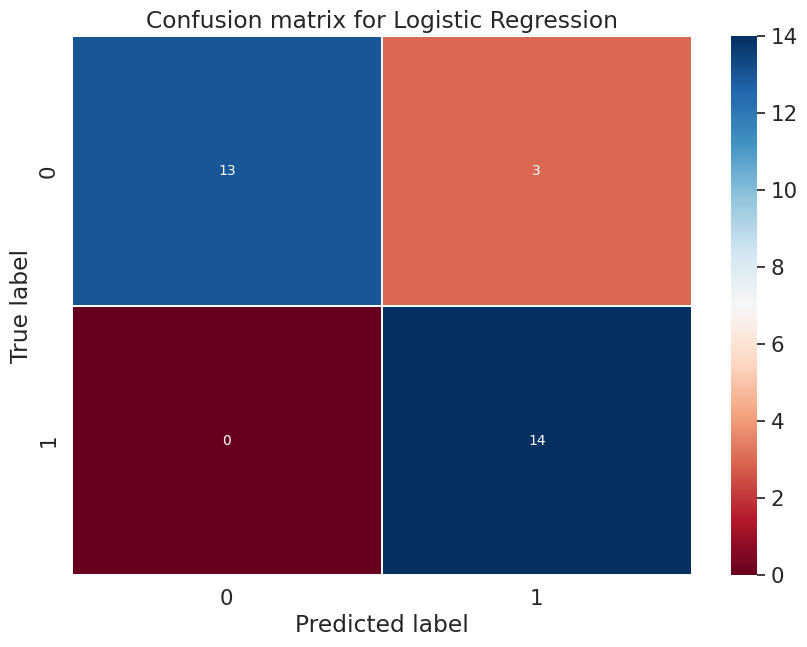

In [46]:
matrix_lr = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(matrix_lr, annot=True, annot_kws={'size':10}, linewidths=0.2, cmap ="RdBu")
plt.xticks()
plt.yticks()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix for Logistic Regression')
plt.show()

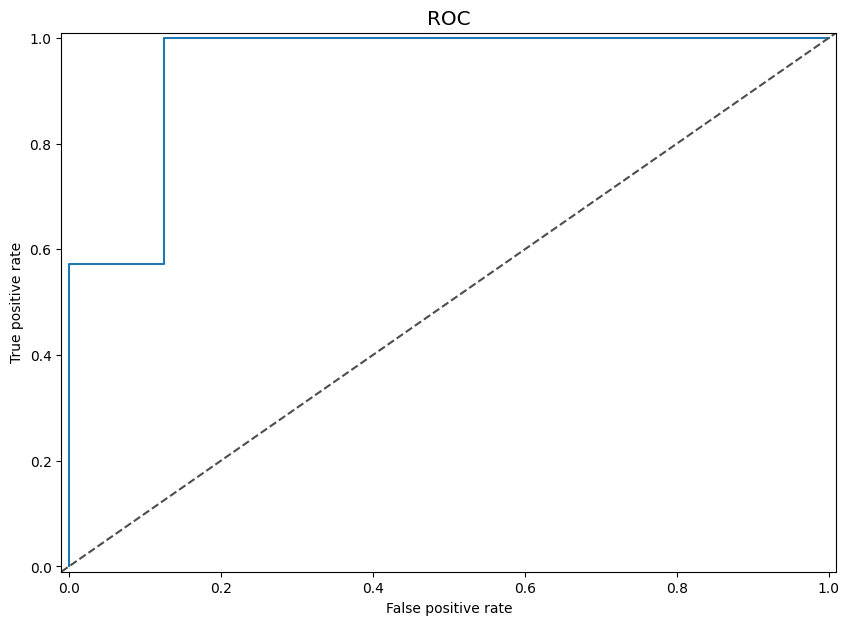

In [47]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(fpr_lr, tpr_lr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.rcParams['font.size'] = 12
plt.title('ROC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [48]:
features = preprocess(train, test, inference=True)
lr_coefficients = pd.DataFrame([lr.coef_[0]], columns = features)
sorted_lr = lr_coefficients.iloc[:, np.argsort(lr_coefficients.loc[0])]

In [49]:
labels = ['Major vessels colored: 0',
          'Thalium stress test: Fixed defect',
         'Sex: Female',
         'Maximum heart rate',
         'Chest pain type: Non-anginal',
         'Exercise-induced angina: False',
         'ST slope: Downsloping',
         'Chest pain type: Asymptomatic',
         'Chest pain type: Atypical',
          'ECG: Abnormality',
          'Fasting blood sugar > 120 mg/dL: True',
          'Major vessels colored: 4',
          'ST slope: Upsloping',
          'Thalium stress test: Fixed defect',
          'Age',
          'ECG: Hypertrophy',
          'Fasting blood sugar > 120 mg/dL: False',
          'ECG: Normal',
          'Cholesterol',
          'Major vessels colored: 3',
          'Resting blood pressure',
          'ST slope: Flat',
          'Exercised-induced angina: True',
          'Major vessels colored: 1',
          'Major vessels colored: 2',
          'ST depression',
          'Sex: Male',
          'Thalium stress test: Reversible defect',
          'Chest pain type: Typical'
         ]

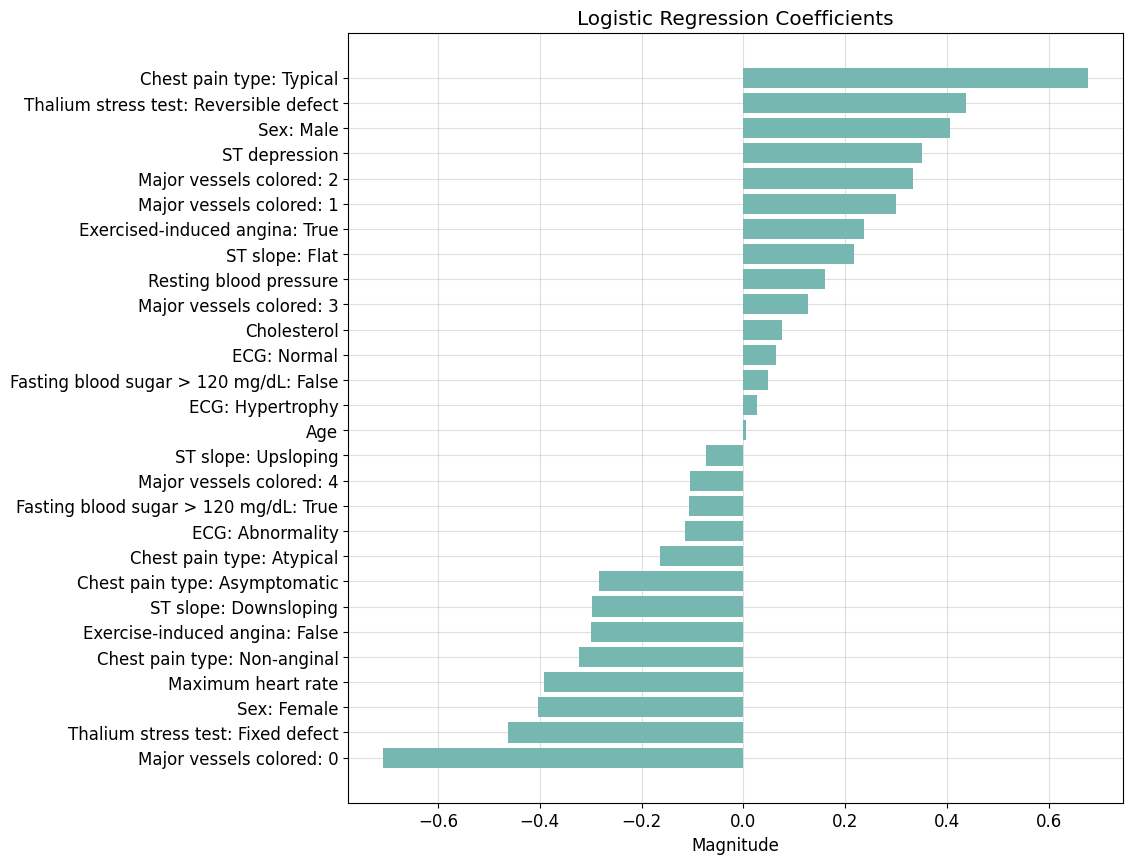

In [50]:
plt.figure(figsize=(10,10))
plt.rc('axes', axisbelow=True)
ax = plt.barh(y=labels, width=sorted_lr.iloc[0,:], color='#76b7b2')
plt.xlabel('Magnitude')
plt.title('Logistic Regression Coefficients')
plt.grid(alpha=0.4)
plt.show()   